# OIB Radar Crossover Analysis 
Notebook designed to analyze crossover disagreement in measurements between crossing radar tracks

At each intersecting radar profile where an interpretation has been made we have a measurement of (i.) surface elevation, (ii.) bed elevation, (iii.) ice thickness, (iv.) surface amplitude, and (v.) bed amplitude. We can compare all of these values at each radar profile intersection to analyze the disagreements in our dataset.

This loosely follows the methods of Herkommer and Whitney, 1994

BST 20211123


### psuedocode ###
1. read in dataset containing RAGU radar picks
2. find all intersection points for all radar profiles in our dataset
    2a. our dataset contains points corresponding to each "trace" in all of our radar profiles where interpretations have been made. in order to find the intersection between all our radar profiles we'll take advantage of shapely's intersection method - this requires us to first convert all points in each profile to individual linestrings
3. intersections won't fall directly where we have measurements. So we'll linearly interpolate measurements at the two closest points surrounding our intersection for each profile
4. build a statistical dataset with difference in the measurements of interest between tracks at each intersection

In [24]:
### impots ###
import sys, os, itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import pyproj
from geopandas import GeoDataFrame
from shapely.geometry import Point, LineString
from datetime import datetime
pd.set_option('display.max_rows', 500)

# let's set some default plotting params
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 8]
mpl.rcParams.update({'font.size': 12})
plt.rcParams["font.family"] = "Times New Roman"

In [18]:
### function declarations ###

def project_array(x=None, y=None, from_epsg=4326, to_epsg=3338, always_xy=True):
    """
    use pyproj to project our x,y data
    
    inputs:
    x = input x value array
    y = input y value array
    from_epsg = source epsg code for our x,y points
    to_epsg = destination epsg code for our points
    always_xy = boolean, whether or not input points are always in x,y order
    
    returns:
    fx = x points projected from_epsg to_epsg
    fy = y points projected from_epsg to_epsg
    """
    tform = pyproj.Transformer.from_crs(crs_from=from_epsg, crs_to=to_epsg, always_xy=always_xy)
    fx, fy = tform.transform(x, y)
    return fx,fy




R = 6367000     # earth's radius in meters

def haversinedist_point_array(plon, plat, lonarray, latarray):
    """
    calculate the great circle distance from all points in an array to a specified point on earth's surface.
    locations specified in decimal degrees.
    
    modified from : https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    
    inputs:
    plon = float
    plat = float
    lonarray = Nx1 array containing longitude values
    latarray= Nx1 array containing latitude values
    
    returns:
    m = Nx1 array containing distance from all lon,lat points to point plon,plat
    
    example call:
    distance_array = haversinedist_point_array(plon=-140.5, plat=90.5, lonarray=[-140.1,-140.7,-141.2], latarray=[61.2,60.3,60.7])
    """
    plon, plat, lonarray, latarray = map(np.radians, [plon, plat, lonarray, latarray])  # map lat, lon to radians

    dlon = lonarray - plon
    dlat = latarray - plat

    a = np.sin(dlat/2.0)**2 + np.cos(plat) * np.cos(latarray) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    m = R * c
    return m



def track_crossings(lines):
    """ 
    create list of all intersecting objects.
    
    we need to take in linestrings formed from points (traces) along each radar profile in our dataset and find all the intersecting lines.
    
    we'll use shapely's intersection method for this purpose. ultimately what we want to return is a list contianing the location of each 
    crossing and the profiles participating in said crossing.
    
    input: 
    lines = list containing the name of each radar profile followed by a shapely linestring formed by all points in said profile
    
    returns:
    crossings = list containing the name of each set of intersecting radar profiles and the shapely point corresponding to their intersection
    """
    crossings = []
    for line1,line2 in  itertools.combinations(lines, 2):
        if  line1[1].intersects(line2[1]):
            crossing = line1[1].intersection(line2[1])
            if "Point" == crossing.type:
                crossings.append([line1[0],line2[0],crossing])
            elif "MultiPoint" == crossing.type:
                for pt in crossing:
                    crossings.append([line1[0],line2[0],pt])
            elif "MultiLineString" == crossing.type:
                multiLine = [line for line in crossing]
                first_coords = multiLine[0].coords[0]
                last_coords = multiLine[len(multiLine)-1].coords[1]
                crossings.append([line1[0],Point(first_coords[0], first_coords[1])])
                crossings.append([line2[0],Point(last_coords[0], last_coords[1])])
    return crossings

def interp3d(x1, y1, z1, x2, y2, z2 , x, y):
    """
    since we won't actually have measurements directly at each intersection point between radar profiles, we'll need to interpolate from our closes measurements
    
    we'll use trilinear interpolation to get our value of interest between two 3d points
    
    essentially, we have two x,y,z points surrounding our intersection location where we know x,y and need z
    
    note: i'm thinking our locations should be in projected crs for this, which they currently are not
    
    inputs:
    x1 = x location 1
    y1 = y loation 1
    z1 = z location 1
    x2 = x location 2
    y2 = y loation 2
    z2 = z location 2
    x = x location at intersection
    y = y location at intersection
    
    returns:
    z = interpolated z value at location x,y
    """
    if (x1==x2) & (y1==y2):
        z = (z1+z2)/2
    else:
        b1 = np.sqrt((x2 - x1)**2 + (y2 - y1 )**2)  # hypot between given x and y points
        b2 = np.sqrt((x - x1)**2 + (y - y1)**2)     # hypot between first x and y point and point of interest
        z =   z1 + b2*(z2 - z1) / b1                # calculate z value at point of interest

    return z


# build dataset comparing measured values at each intersection
def comp_crossings(picks_df, crossings_list, thresh_dist):

    rem_idx = []        # indices of crossings list elements to remove if distance between closes points to  intersection are above threshold
    # initialize arrays to hold interpolated values
    lon_arr = np.array(())
    lat_arr = np.array(())
    track0_arr = np.array(())
    track1_arr = np.array(())
    zsrf0_arr = np.array(())
    zsrf1_arr = np.array(())
    zbed0_arr = np.array(())
    zbed1_arr = np.array(())
    thick0_arr = np.array(())
    thick1_arr = np.array(())

    # loop through crossings
    for _i, crossing in enumerate(crossings_list):
        pt = crossing[2]
        df_sub0 = picks_df[picks_df["track"]==crossing[0]]
        df_sub1 = picks_df[picks_df["track"]==crossing[1]]
        
        # get distance of each point in track to intersection point
        dist0 = haversinedist_point_array(df_sub0["lon"].to_numpy(), df_sub0["lat"].to_numpy(), 
                pt.x, pt.y)
        dist1 = haversinedist_point_array(df_sub1["lon"].to_numpy(), df_sub1["lat"].to_numpy(), 
                pt.x, pt.y)

        # make sure closest point to each intersection is below threshold distance specified
        if dist0.min() < thresh and dist1.min() < thresh_dist:
            # sort distances to get two closest indices
            t0sort = np.argsort(dist0)
            t1sort = np.argsort(dist1)

            # get lon, lat, surface elev, thickness, and bed elev for two closest points to intersection for each track
            x0 = [df_sub0["lon"].iloc[t0sort[0]], df_sub0["lon"].iloc[t0sort[1]]]
            y0 = [df_sub0["lat"].iloc[t0sort[0]], df_sub0["lat"].iloc[t0sort[1]]]
            zsrf0 = [df_sub0["srf_elev"].iloc[t0sort[0]], df_sub0["srf_elev"].iloc[t0sort[1]]]
            zbed0 = [df_sub0["bed_elev"].iloc[t0sort[0]], df_sub0["bed_elev"].iloc[t0sort[1]]]
            thick0 = [df_sub0["srf_bed_thick"].iloc[t0sort[0]], df_sub0["srf_bed_thick"].iloc[t0sort[1]]]

            x1 = [df_sub1["lon"].iloc[t1sort[0]], df_sub1["lon"].iloc[t1sort[1]]]
            y1 = [df_sub1["lat"].iloc[t1sort[0]], df_sub1["lat"].iloc[t1sort[1]]]
            zsrf1 = [df_sub1["srf_elev"].iloc[t1sort[0]], df_sub1["srf_elev"].iloc[t1sort[1]]]
            zbed1 = [df_sub1["bed_elev"].iloc[t1sort[0]], df_sub1["bed_elev"].iloc[t1sort[1]]]
            thick1 = [df_sub1["srf_bed_thick"].iloc[t1sort[0]], df_sub1["srf_bed_thick"].iloc[t1sort[1]]]

            # get linearly interpolated values for each track at intersection point
            zsrf0_cross = interp3d(x0[0],y0[0],zsrf0[0],x0[1],y0[1],zsrf0[1],pt.x,pt.y)
            zbed0_cross = interp3d(x0[0],y0[0],zbed0[0],x0[1],y0[1],zbed0[1],pt.x,pt.y)
            thick0_cross = interp3d(x0[0],y0[0],thick0[0],x0[1],y0[1],thick0[1],pt.x,pt.y)

            zsrf1_cross = interp3d(x1[0],y1[0],zsrf1[0],x1[1],y1[1],zsrf1[1],pt.x,pt.y)
            zbed1_cross = interp3d(x1[0],y1[0],zbed1[0],x1[1],y1[1],zbed1[1],pt.x,pt.y)
            thick1_cross = interp3d(x1[0],y1[0],thick1[0],x1[1],y1[1],thick1[1],pt.x,pt.y)

            # add values to arrays
            lon_arr = np.append(lon_arr, pt.x)
            lat_arr = np.append(lat_arr, pt.y)

            track0_arr = np.append(track0_arr, crossing[0])
            zsrf0_arr = np.append(zsrf0_arr, zsrf0_cross)
            zbed0_arr = np.append(zbed0_arr, zbed0_cross)
            thick0_arr = np.append(thick0_arr, thick0_cross)

            track1_arr = np.append(track1_arr, crossing[1])
            zsrf1_arr = np.append(zsrf1_arr, zsrf1_cross)
            zbed1_arr = np.append(zbed1_arr, zbed1_cross)
            thick1_arr = np.append(thick1_arr, thick1_cross)        

        # if closest point is further than threshold, remove crossing
        else:
            rem_idx.append(_i)

    # remove crossings where closes points are above threshold distance
    for idx in sorted(rem_idx, reverse = True):  
        del crossings[idx] 

    # build df
    crossings_df = pd.DataFrame({"lon":lon_arr, "lat":lat_arr,
                                "track0":track0_arr, "zsrf0":zsrf0_arr, "zbed0":zbed0_arr, "thick0":thick0_arr,
                                "track1": track1_arr, "zsrf1":zsrf1_arr, "zbed1":zbed1_arr, "thick1":thick1_arr,
                                "dzsrf":np.abs(zsrf0_arr-zsrf1_arr), "dzbed":np.abs(zbed0_arr-zbed1_arr),
                                "dthick":np.abs(thick0_arr-thick1_arr)})
    return crossings_df


# create histogram to show crossover statistics
def plot_stats(crossings_df):
    # plot stats
    stats_df = crossings_df[["dzsrf","dzbed","dthick"]]
    stats_df = crossings_df[["dzbed"]]

    fig, ax = plt.subplots(1,sharex=True,figsize=((6.5,2)))
    for i, (name, col) in enumerate(stats_df.iteritems()):
        # ax = axes[
        col.hist(ax=ax,bins=len(col)//10)
        mn = ax.axvline(col.mean(), color='r', linestyle='dashed', linewidth=1,label='Mean',zorder=1000)
        std = ax.axvline(col.mean()-col.std(), color='k', linestyle='dashed', linewidth=1,label=r'$1\sigma$',zorder=1000)
        ax.axvline(col.mean()+col.std(), color='k', linestyle='dashed', linewidth=1,zorder=1000)
        # ax2 = col.plot.kde(ax=ax, secondary_y=True, label="PDF",zorder=100)
        # ax2.set_ylim(0)
        ax.set_xlim([0, 20 * np.rint(np.nanmax(col)/20)])
        ax.text(x=.85,y=.4,s='N = ' + str(len(col)), transform=ax.transAxes)
        ax.legend((mn, std), ('Mean', r'$1\sigma$'), loc='upper right')
        print("mean " + name + ": " + str(col.mean()) + " +/- " + str(col.std()))


    ax.grid(False)
    ax.set_ylabel('Crossings')
    ax.set_xlabel("Measurement Disagreement [m]")
    return fig

Load OIB radar picks for Malaspina Glacier

In [7]:
### params ###
dpath = "C:/Users/btober/OneDrive/Documents/data/radar/mala/"                               # data path
df = pd.read_csv(dpath + 'lobe_merged_pk_bst.csv')                                          # use pandas to load dataset with picks
df = df[df.bed_elev.notnull()]                                                              # filter null points
thresh = 50                                                                                 # specify distance threshold between crossover points [m]

In [15]:
# inspect dataframe
df.head()

,fid,field_1,track,trace,lon,lat,elev,srf_sample,srf_twtt,srf_elev,srf_amp,bed_sample,bed_twtt,bed_elev,bed_amp,srf_bed_thick,geometry
0,53707,53706,IRARES1B_20210502-223515,1167,-140.544149,60.098910,728.54380,129,0.000001,535.177665,1.486805,753,0.000008,8.166252,0.066885,527.011413,POINT (-140.54415 60.09891)
1,53708,53707,IRARES1B_20210502-223515,1168,-140.544165,60.098931,728.46180,129,0.000001,535.095665,1.459012,752,0.000008,8.928822,0.079081,526.166843,POINT (-140.54417 60.09893)
2,53709,53708,IRARES1B_20210502-223515,1169,-140.544182,60.098953,728.38180,129,0.000001,535.015665,1.448283,752,0.000008,8.848822,0.087145,526.166843,POINT (-140.54418 60.09895)
3,53710,53709,IRARES1B_20210502-223515,1170,-140.544198,60.098974,728.30325,129,0.000001,534.937115,1.398397,751,0.000008,9.614841,0.095400,525.322273,POINT (-140.54420 60.09897)
4,53711,53710,IRARES1B_20210502-223515,1171,-140.544214,60.098996,728.22625,129,0.000001,534.860115,1.326183,751,0.000008,9.537841,0.100863,525.322273,POINT (-140.54421 60.09900)


Filter dataframe to keep only IRARES1B_2021* profiles

In [ ]:
# filter and keep just 2021 tracks - this can be achieved using pandas .str.contains() method


Convert lon, lat points in dataframe which are currently unprojected decimal-degrees to a projected coordinate system - let's use epsg:3338 alaska albers

This will allow us to get distance between points in meters

In [ ]:
# use our project_array function defined above to convert df["lon"], df["lat"] to df["x"],df["y"]
df["x"], df["y"] = #

To look at crossover disagreement in reflectivity, we'll want to convert amplitudes to power in deciBels

$$P_{dB} = \log_{10}(a^{2})$$
$$P_{dB} = 20* \log_{10}(a)$$

where $P_{dB}$ is the power of our radar return in decibels, and $a$ is the amplitude of our return.

In [ ]:
df["p_db"] = #

Now let's get all of our profile crossings. This requires several steps:

1. convert all x,y points to shapely point objects
2. group all points by the "track" field and convert to linestrings
3. create a list containing the track name followed by the shapely linestring for each profile
4. use our track_crossings() method to get the intersections of all our profiles

In [11]:
# convert points in each track to linestring grouped by track
# zip the coordinates into a point object and convert to a shapely geodataframe
geometry = [Point(xy) for xy in zip(df.lon, df.lat)]
gdf = GeoDataFrame(df, geometry=geometry)

# aggregate points by track using groupby and set as a linestring
gdf2 = gdf.groupby(["track"])["geometry"].apply(lambda x: LineString(x.tolist()))
gdf2 = GeoDataFrame(gdf2, geometry="geometry")

# compile list of lines with linestring
lines = list(gdf2["geometry"])
lines = [tuple((fname, lines[_i])) for _i, fname in enumerate(gdf2.index.values)]

# get all track crossings
crossings = track_crossings(lines)

# inspect output
# each sublist should have: ['track0', 'track1', shapelyPoint]
print(crossings[0])
# the length of our crossings list tells us how many individual radar profile intersections we have - this will likely be reduced when we account for our defined distance threshold
print(len(crossings))

['IRARES1B_20210502-223515', 'IRARES1B_20210503-000556', <shapely.geometry.point.Point object at 0x000001D8475482B0>]
116


C:\Users\btober\AppData\Local\Temp\ipykernel_3220\2769293271.py:50: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for pt in crossing:


Now that we have a list of all tracks and where they cross, let's build our dataset comparing measurements at each intersection

In [20]:
# compare radar measurements at each crossing
crossings_df = comp_crossings(df, crossings, thresh)
# inspect output
crossings_df.head()

,lon,lat,track0,zsrf0,zbed0,thick0,track1,zsrf1,zbed1,thick1,dzsrf,dzbed,dthick
0,-140.514218,60.042468,IRARES1B_20210502-223515,521.756285,-134.448261,656.204546,IRARES1B_20210503-000556,520.385986,-156.114237,676.500224,1.370298,21.665976,20.295678
1,-140.490004,60.017888,IRARES1B_20210502-223515,487.655461,-63.848470,551.503931,IRARES1B_20210503-002426,487.147366,-42.397756,529.545122,0.508094,21.450714,21.958809
2,-140.467744,59.992891,IRARES1B_20210502-223515,469.493024,-53.295540,522.788564,IRARES1B_20210503-004101,468.289581,-35.918456,504.208037,1.203443,17.377083,18.580527
3,-140.446353,59.967754,IRARES1B_20210502-223515,442.645317,-1.027548,443.672865,IRARES1B_20210503-005632,443.193001,-7.807153,451.000154,0.547684,6.779605,7.327289
4,-140.530405,60.060221,IRARES1B_20210502-223515,540.077891,-281.855952,821.933843,IRARES1B_20210503-011452,539.207073,-303.647918,842.854991,0.870818,21.791966,20.921148


In [21]:
# further inspect output stats of crossover disagreement
crossings_df[['dzsrf','dzbed','dthick']].describe()


,dzsrf,dzbed,dthick
count,114.000000,114.000000,114.000000
mean,7.241279,16.745682,11.946328
std,11.003362,14.205251,10.816308
min,0.003957,0.189045,0.000000
25%,0.413039,6.335463,4.222932
50%,0.949791,14.048927,9.290269
75%,16.277430,21.778303,15.993112
max,62.868831,64.901967,59.119850


mean dzbed: 16.745681513532162 +/- 14.205250813529286


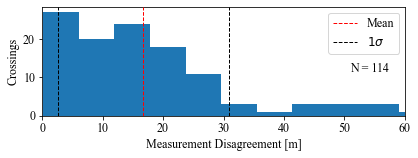

In [23]:
# plot stats
fig = plot_stats(crossings_df)
# fig.savefig(dpath + "bed_xover_hist.png", dpi=300)

In [ ]:
# output crossover comparison df
# crossings_df.to_csv(dpath + "malaspina_xover.csv", index=False)